In [1]:
import torch
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import pickle
from alexnet_pytorch import AlexNet
import copy
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import time

In [2]:
def unpickle_meta(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo)
    return dict['label_names']

In [3]:
def print_classes(label_names):
    for i in range(0, 10):
        print(str(i) + " : " + label_names[i] + "  ")

In [4]:
# Just so we know what each label means 
label_names = unpickle_meta('batches.meta')
print_classes(label_names)

0 : airplane  
1 : automobile  
2 : bird  
3 : cat  
4 : deer  
5 : dog  
6 : frog  
7 : horse  
8 : ship  
9 : truck  


In [5]:
# for reproduction purposes
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [6]:
# extracting the data
# calculating mean and standard deviation for normalization purposes
train_data = datasets.CIFAR10(root ='.data', train = True, download = True)
mean_vals = train_data.data.mean(axis = (0,1,2))/255
std_vals = train_data.data.std(axis = (0,1,2))/255

print(f'Means: {mean_vals}')
print(f'Stds: {std_vals}')

Files already downloaded and verified
Means: [0.49139968 0.48215841 0.44653091]
Stds: [0.24703223 0.24348513 0.26158784]


In [7]:
# getting transforms set up for augmentation of data
train_transforms = transforms.Compose([
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(32, padding = 2),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = mean_vals, 
                                                std = std_vals)
                       ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = mean_vals, 
                                                std = std_vals)
                       ])
print(train_transforms)
print(test_transforms)

Compose(
    RandomRotation(degrees=[-5.0, 5.0], interpolation=nearest, expand=False, fill=0)
    RandomHorizontalFlip(p=0.5)
    RandomCrop(size=(32, 32), padding=2)
    ToTensor()
    Normalize(mean=[0.49139968 0.48215841 0.44653091], std=[0.24703223 0.24348513 0.26158784])
)
Compose(
    ToTensor()
    Normalize(mean=[0.49139968 0.48215841 0.44653091], std=[0.24703223 0.24348513 0.26158784])
)


In [8]:
# now, can load the dataset with the created transforms
train_data = datasets.CIFAR10('.data', 
                              train = True, 
                              download = True, 
                              transform = train_transforms)

test_data = datasets.CIFAR10('.data', 
                             train = False, 
                             download = True, 
                             transform = test_transforms)
print(train_data)
print(test_data)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: .data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-5.0, 5.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               RandomCrop(size=(32, 32), padding=2)
               ToTensor()
               Normalize(mean=[0.49139968 0.48215841 0.44653091], std=[0.24703223 0.24348513 0.26158784])
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: .data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.49139968 0.48215841 0.44653091], std=[0.24703223 0.24348513 0.26158784])
           )


In [9]:
# performing the data splitting
SPLIT_COEFF = 0.8

n_train_samples = int(len(train_data) * SPLIT_COEFF)
n_valid_samples = len(train_data) - n_train_samples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_samples, n_valid_samples])
print(n_train_samples)
print(n_valid_samples)

print(train_data)
print(valid_data)

40000
10000


In [10]:
# making sure we got test transforms for valid_data
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [11]:
# printing out the resulting number of samples and making sure we got it right
print(f'Number of training samples: {len(train_data)}')
print(f'Number of validation samples: {len(valid_data)}')
print(f'Number of testing samples: {len(test_data)}')

Number of training samples: 40000
Number of validation samples: 10000
Number of testing samples: 10000


In [12]:
# doing some permutation so we can use matplotlib to display images for visual verification
# will define a function for it
def plot_pics(images, labels, classes, normalize = False):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image_min = image.min()
            image_max = image.max()
            image.clamp_(min = image_min, max = image_max)
            image.add_(-image_min).div_(image_max - image_min + 1e-5)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


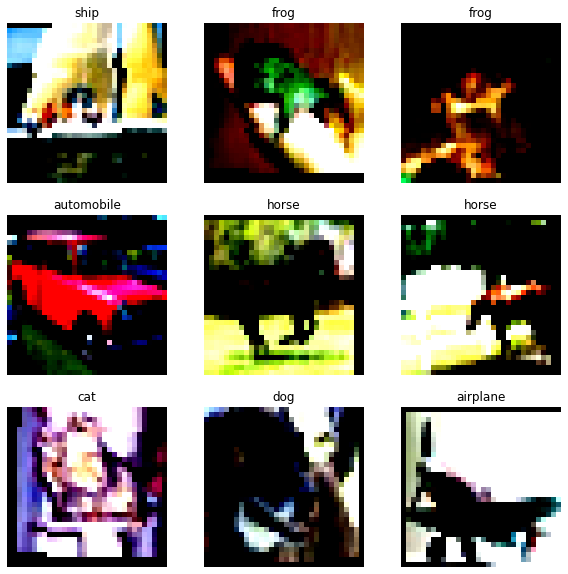

In [13]:
# will plot the first 10 images for visualization and familiarization
# might need to do some clipping
NUM_IM = 10
images, labels = zip(*[(image, label) for image, label in [train_data[i] for i in range(NUM_IM)]])

classes = test_data.classes
plot_pics(images, labels, classes)

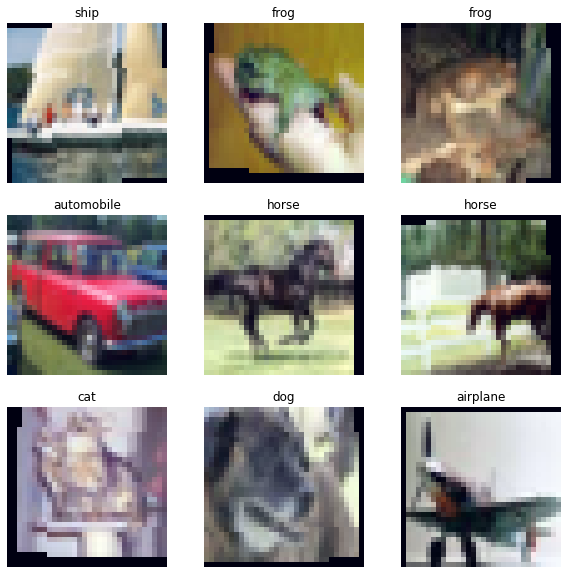

In [14]:
# pictures look terrible, so will try to do some renormalization to have each pixel in range between 0 and 1
plot_pics(images, labels, classes, normalize=True)

In [15]:
# looks much better now for identification of an eye
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [16]:
# Will try out some Sobel filters
def plot_filter(images, filter, normalize = True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
    filter = torch.FloatTensor(filter).unsqueeze(0).unsqueeze(0).cpu()
    filter = filter.repeat(3, 3, 1, 1)
    
    n_images = images.shape[0]

    filtered_images = F.conv2d(images, filter)

    images = images.permute(0, 2, 3, 1)
    filtered_images = filtered_images.permute(0, 2, 3, 1)

    fig = plt.figure(figsize = (25, 5))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(2, n_images, i+1)
        ax.imshow(image)
        ax.set_title('Original')
        ax.axis('off')

        image = filtered_images[i]

        if normalize:
            image = normalize_image(image)
        
        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image)
        ax.set_title(f'Filtered')
        ax.axis('off');

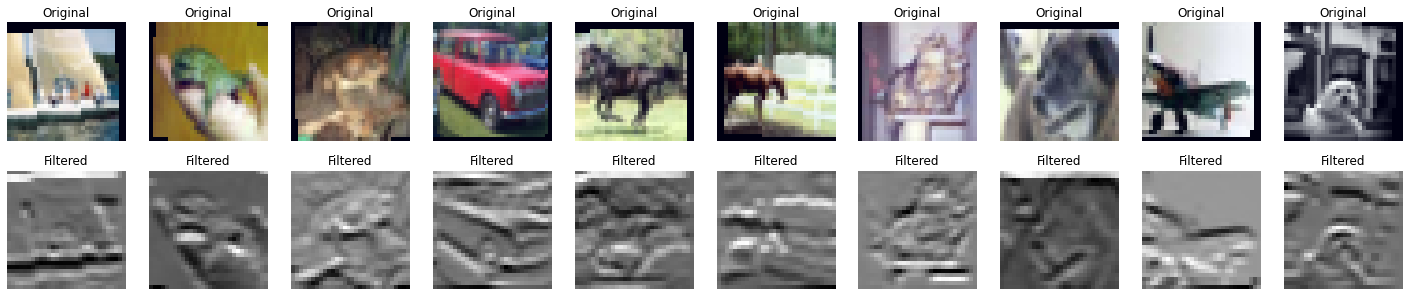

In [17]:
# Horizontal orientation line detection
NUM_IM = 10

images = [image for image, label in [train_data[i] for i in range(NUM_IM)]]

horizontal_filter = [[-1, -2, -1],
                     [ 0,  0,  0],
                     [ 1,  2,  1]]

plot_filter(images, horizontal_filter)

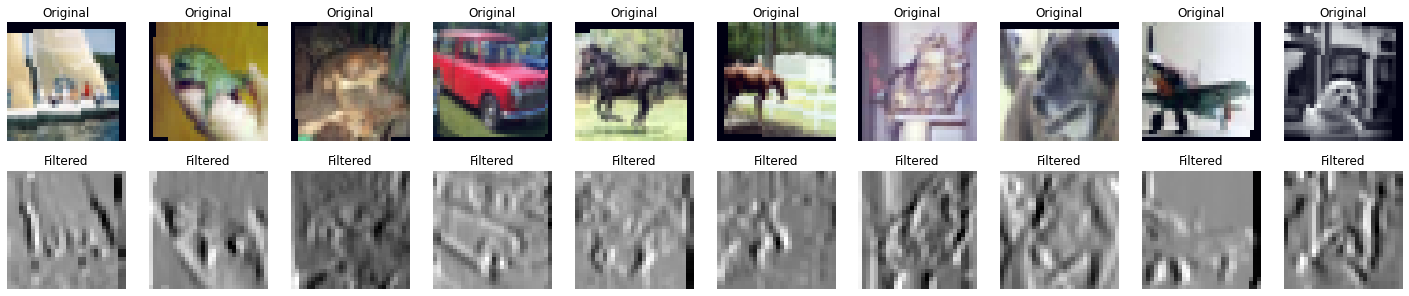

In [18]:
# Same but for verrtical
vertical_filter = [[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]]

plot_filter(images, vertical_filter)

In [19]:
# Subsampling/pooling immitation
def plot_subsample(images, pool_type, pool_size, normalize = True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
    
    if pool_type.lower() == 'max':
        pool = F.max_pool2d
    elif pool_type.lower() in ['mean', 'avg']:
        pool = F.avg_pool2d
    else:
        raise ValueError(f'pool_type must be either max or mean, got: {pool_type}')
    
    n_images = images.shape[0]

    pooled_images = pool(images, kernel_size = pool_size)

    images = images.permute(0, 2, 3, 1)
    pooled_images = pooled_images.permute(0, 2, 3, 1)

    fig = plt.figure(figsize = (25, 5))
    
    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(2, n_images, i+1)
        ax.imshow(image)
        ax.set_title('Original')
        ax.axis('off')

        image = pooled_images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image)
        ax.set_title(f'Subsampled')
        ax.axis('off');

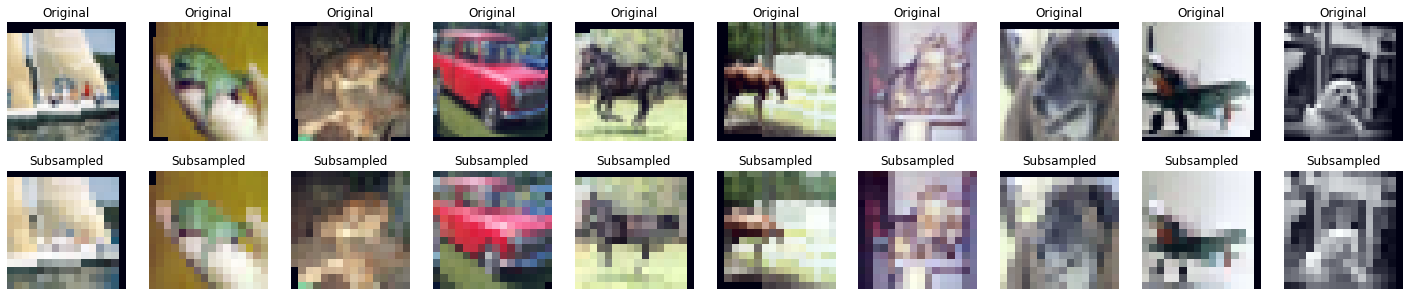

In [20]:
# Looks like some info is lost high filtration
plot_subsample(images, 'max', 2)

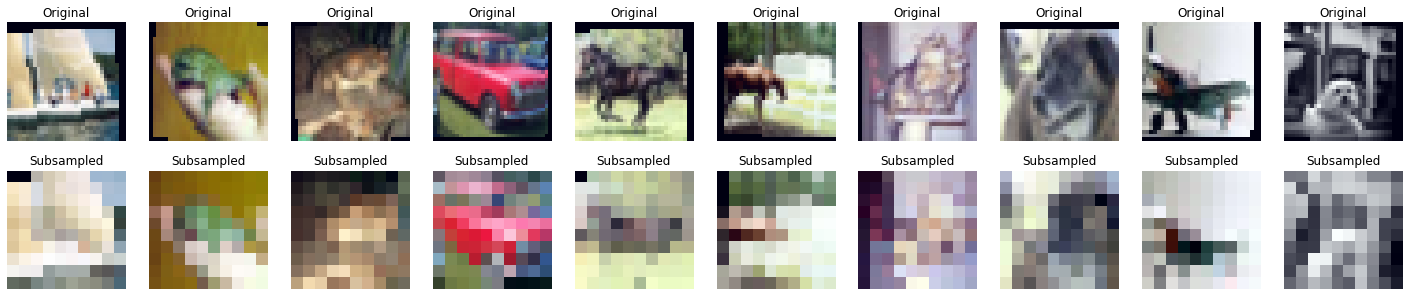

In [21]:
plot_subsample(images, 'max', 3)

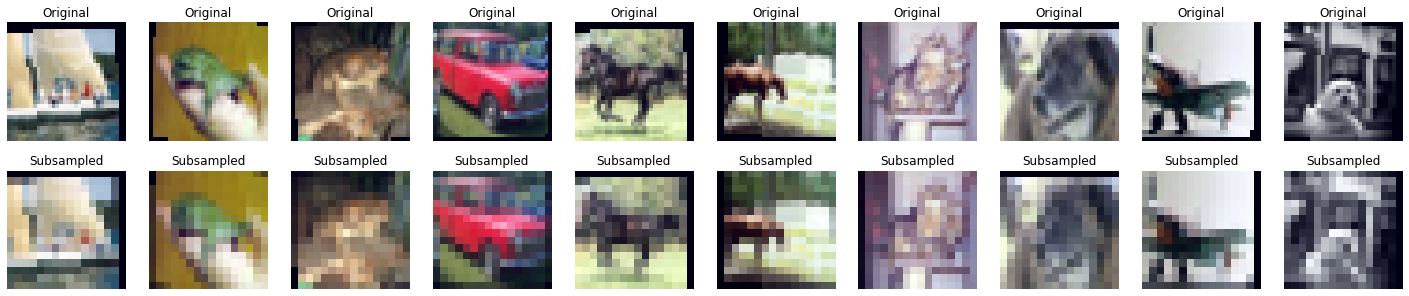

In [22]:
plot_subsample(images, 'avg', 2)

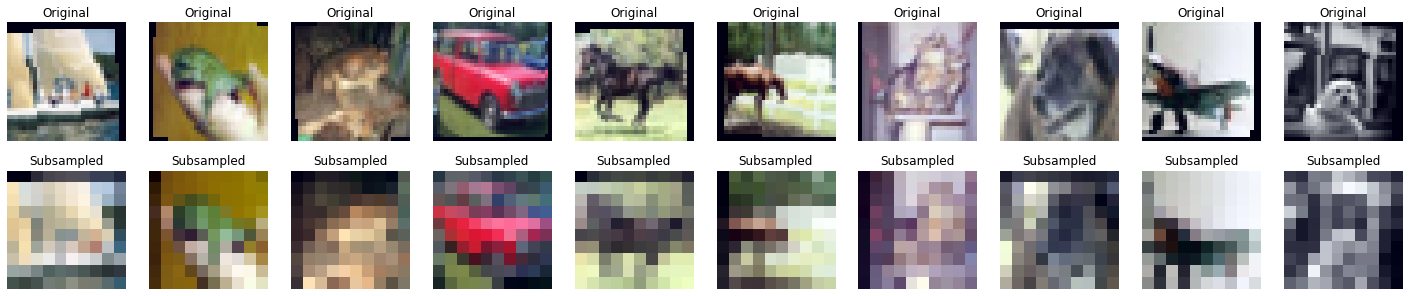

In [23]:
plot_subsample(images, 'avg', 3)

In [24]:
# might need to use 1024 for batch size
BATCH_SIZE = 256

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

In [25]:
# AlexNet init
class AlexNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1), #in_channels, out_channels, kernel_size, stride, padding
            nn.MaxPool2d(2), #kernel_size
            nn.ReLU(inplace = True),
            nn.Conv2d(64, 192, 3, padding = 1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace = True),
            nn.Conv2d(192, 384, 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(384, 256, 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(256, 256, 3, padding = 1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace = True)
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace = True),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [26]:
# Instantiating the created model for  10 classes
OUTPUT_DIM = 10

model = AlexNet(OUTPUT_DIM)

In [27]:
# Need to consider # of train parametres before training
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,272,266 trainable parameters


In [28]:
# Going to apply Xavier and Glorot normalizations, and for both layers have zeros as bias terms
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity = 'relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain = nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

In [29]:
model.apply(initialize_parameters)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

In [30]:
# Learning rate and loss
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        #model resetting
        torch.save(model.state_dict(), 'params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            lrs.append(lr_scheduler.get_last_lr()[0])

            #update lr
            lr_scheduler.step()
            
            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        model.load_state_dict(torch.load('params.pt'))

                    
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        
        x = x.to(self.device)
        y = y.to(self.device)
        
        y_pred, _ = self.model(x)
                
        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

In [31]:
# range finder for the learning rate plus will create an optimizer to combine with the learning rate
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr = START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [32]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

Stopping early, the loss has diverged


In [33]:
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

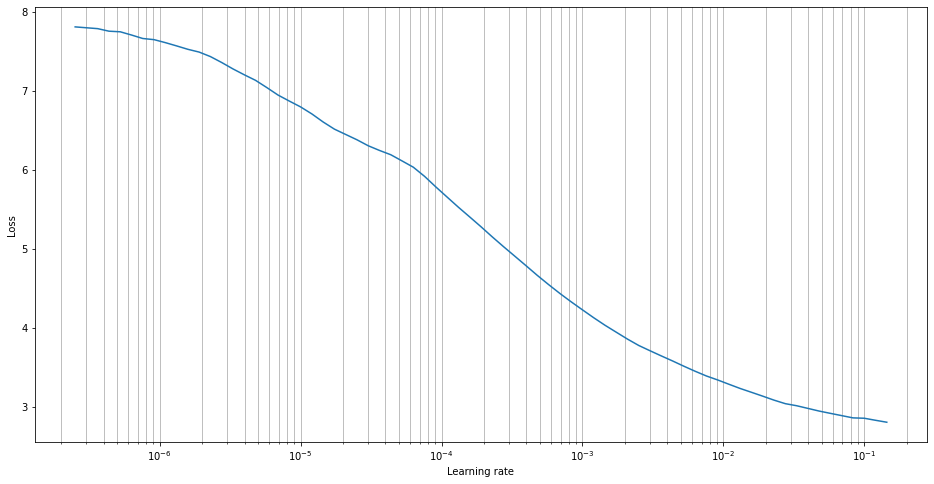

In [34]:
plot_lr_finder(lrs, losses)

In [35]:
# Based on the plot we want to choose the loss where it starts to flatten and decrese it by 1e-1,
# so could will take 1e-2 and therefore decresing by 1e-1 we have 1e-3
FOUND_LR = 1e-3

optimizer = optim.Adam(model.parameters(), lr = FOUND_LR)

In [36]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [37]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [38]:
# will need eval loop to mute the dropout
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [39]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [40]:
# did not have enough time to run more EPOCHS, so decided on 10
# Got validation loss of about 66% accuracy, but would have been
# higher with more EPOCHS
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'mod_state.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 4m 21s
	Train Loss: 2.574 | Train Acc: 17.09%
	 Val. Loss: 1.806 |  Val. Acc: 30.46%
Epoch: 02 | Epoch Time: 4m 11s
	Train Loss: 1.620 | Train Acc: 38.94%
	 Val. Loss: 1.599 |  Val. Acc: 42.54%
Epoch: 03 | Epoch Time: 4m 11s
	Train Loss: 1.416 | Train Acc: 48.08%
	 Val. Loss: 1.365 |  Val. Acc: 50.40%
Epoch: 04 | Epoch Time: 4m 18s
	Train Loss: 1.307 | Train Acc: 52.78%
	 Val. Loss: 1.215 |  Val. Acc: 56.38%
Epoch: 05 | Epoch Time: 4m 27s
	Train Loss: 1.227 | Train Acc: 55.78%
	 Val. Loss: 1.203 |  Val. Acc: 57.00%
Epoch: 06 | Epoch Time: 4m 20s
	Train Loss: 1.159 | Train Acc: 58.57%
	 Val. Loss: 1.088 |  Val. Acc: 61.46%
Epoch: 07 | Epoch Time: 4m 12s
	Train Loss: 1.107 | Train Acc: 60.55%
	 Val. Loss: 1.057 |  Val. Acc: 63.32%
Epoch: 08 | Epoch Time: 4m 11s
	Train Loss: 1.056 | Train Acc: 62.84%
	 Val. Loss: 1.070 |  Val. Acc: 62.55%
Epoch: 09 | Epoch Time: 4m 12s
	Train Loss: 1.013 | Train Acc: 64.35%
	 Val. Loss: 0.958 |  Val. Acc: 66.75%
Epoch: 10 | Epoch T

In [41]:
model.load_state_dict(torch.load('mod_state.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.956 | Test Acc: 66.06%


In [42]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [43]:
images, labels, probs = get_predictions(model, test_iterator, device)

In [44]:
pred_labels = torch.argmax(probs, 1)

In [45]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

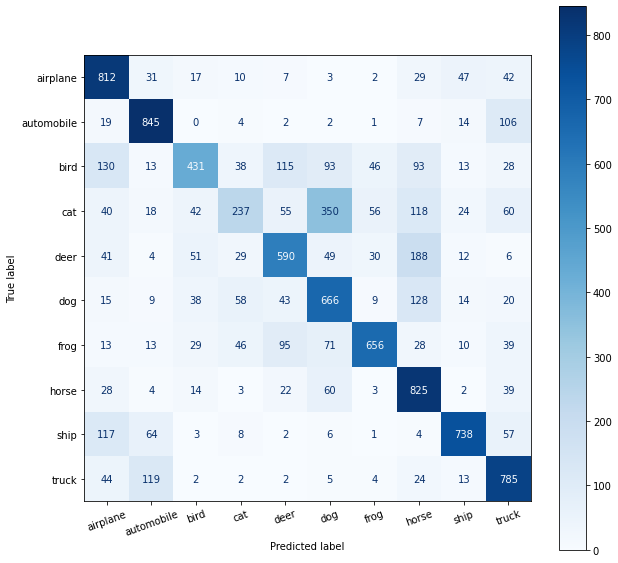

In [46]:
# Plotting the confusion matrix.
# Would have got much much better results with the pre-trained model which includes
# more parameters
plot_confusion_matrix(labels, pred_labels, classes)

In [47]:
corrects = torch.eq(labels, pred_labels)

In [48]:
# Will look at some incorrectly predicted ones for visualization and out of curiosity
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [49]:
def plot_most_incorrect(incorrect, classes, n_images, normalize = True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace = 0.4)

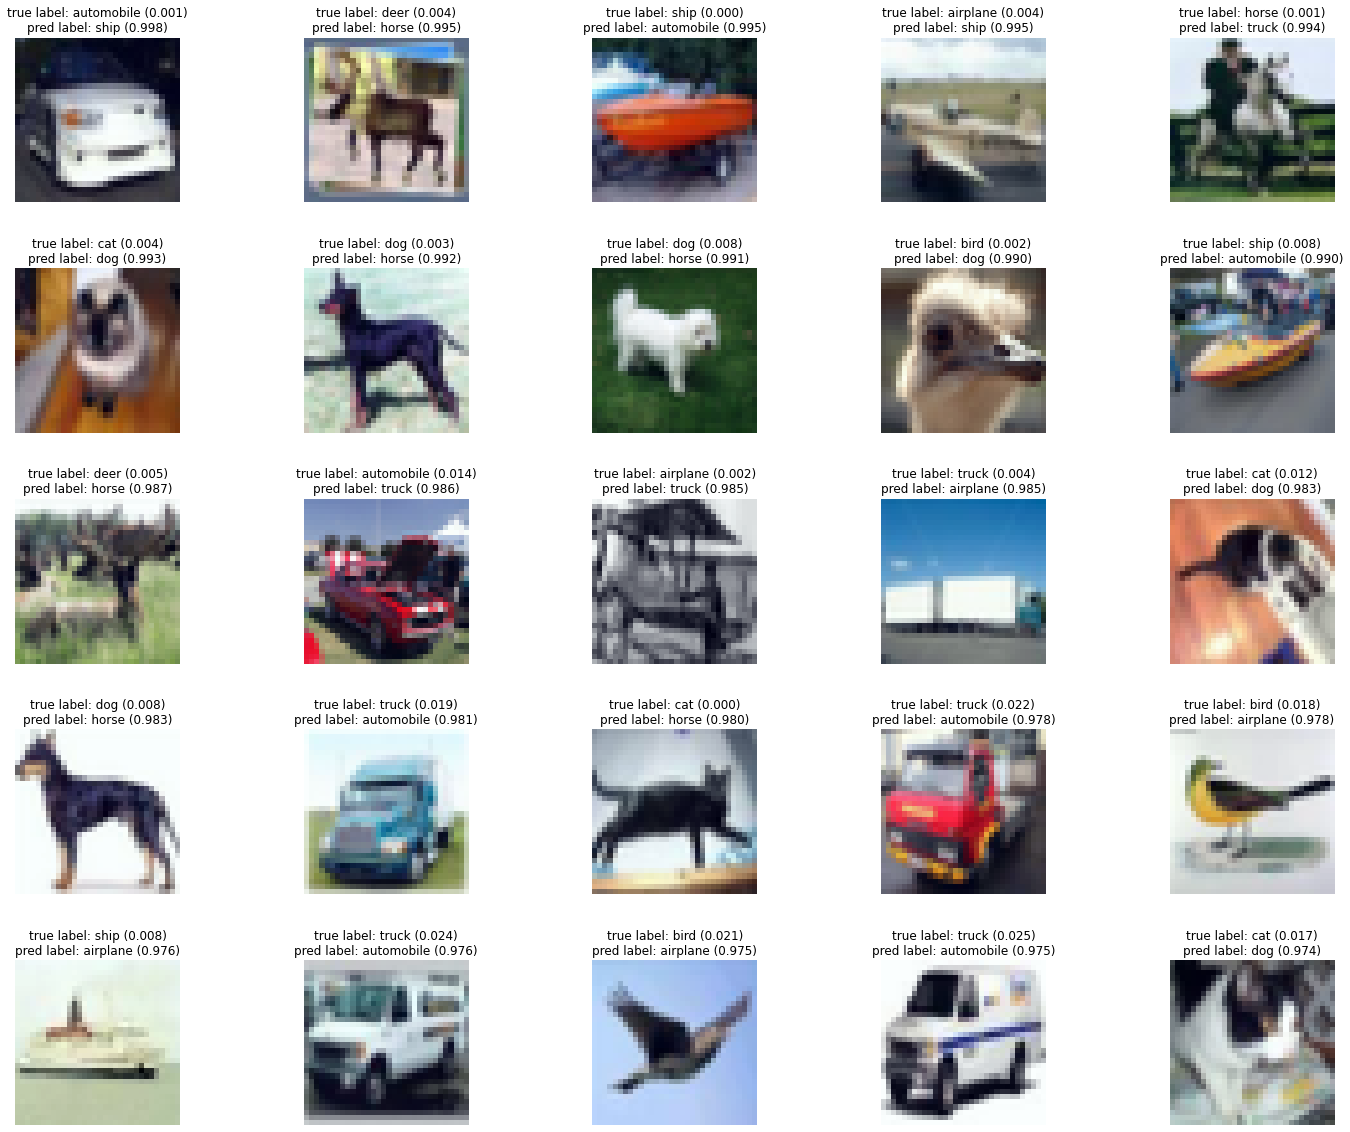

In [50]:
N_IMAGES = 30

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)